Number of species with pubmed count >= 1000: 114
r2: -3.039061829925827
r2 (manual): -3.039061829925827
Pearsonr (heu5 or heu7): 0.3900, Pearsonr (heu5): 0.3778, Pearsonr (heu7): 0.3907
4.47659586913518 0.1076088062568609


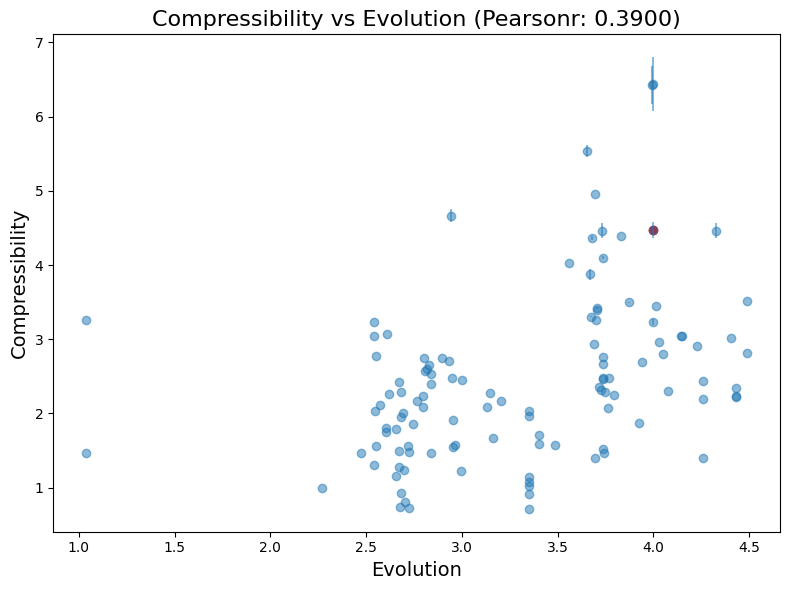

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

def get_compressibility(log_dir):
    rates_upper = np.load(os.path.join(log_dir, 'rates_upper.npy'))
    c = rates_upper[0] - rates_upper.mean()
    # c = rates_upper.max() - rates_upper.mean()
    return c

# read file and ignore the line starting with #
df_pubmed = pd.read_csv('../data/treeoflife.species.pubmed.count.tsv', sep='\t', comment='#')
df_pubmed_ge1000 = df_pubmed[df_pubmed['Publication_count'] >= 1000]
species_pubmed_ge1000 = df_pubmed_ge1000['Species_ID'].tolist()
df_evolution = pd.read_csv('../data/treeoflife.species.evolution.tsv', sep='\t')
df_evolution = df_evolution[df_evolution['Species_ID'].isin(species_pubmed_ge1000)]
print(f'Number of species with pubmed count >= 1000: {len(df_evolution)}')
species2evolution = {row['Species_ID']: row['Evolution'] for _, row in df_evolution.iterrows()}
species2compress = {}
species2compress_heu5 = {}
species2compress_heu7 = {}
species2compress_heu5_std = {}
species2compress_heu7_std = {}
species2compress_std = {}

# log_dir_heu5 = '../logs/logs_interactomes.max_cc.rw1000/heu_5_no_time'
# log_dir_heu7 = '../logs/logs_interactomes.max_cc.rw1000/heu_7_no_time'
log_dir_heu5 = '../logs/logs_interactomes.max_cc.rw2000/heu_5_no_time'
log_dir_heu7 = '../logs/logs_interactomes.max_cc.rw2000/heu_7_no_time'
for species in species2evolution:
    if os.path.exists(os.path.join(log_dir_heu5, f'rate_distortion_{species}_1')):
        compress_heu5_list = []
        compress_heu7_list = []
        compress_list = []
        for i in range(50):
            c_heu5 = get_compressibility(os.path.join(log_dir_heu5, f'rate_distortion_{species}_{i}'))
            c_heu7 = get_compressibility(os.path.join(log_dir_heu7, f'rate_distortion_{species}_{i}'))
            c = max(c_heu5, c_heu7)
            compress_heu5_list.append(c_heu5)
            compress_heu7_list.append(c_heu7)
            compress_list.append(c)
        species2compress_heu5[species] = np.mean(compress_heu5_list)
        species2compress_heu7[species] = np.mean(compress_heu7_list)
        species2compress[species] = np.mean(compress_list)
        species2compress_heu5_std[species] = np.std(compress_heu5_list)
        species2compress_heu7_std[species] = np.std(compress_heu7_list)
        species2compress_std[species] = np.std(compress_list)
    else:
        c_heu5 = get_compressibility(os.path.join(log_dir_heu5, f'rate_distortion_{species}_0'))
        c_heu7 = get_compressibility(os.path.join(log_dir_heu7, f'rate_distortion_{species}_0'))
        c = max(c_heu5, c_heu7)
        species2compress_heu5[species] = c_heu5
        species2compress_heu7[species] = c_heu7
        species2compress[species] = c
        species2compress_heu5_std[species] = 0.0
        species2compress_heu7_std[species] = 0.0
        species2compress_std[species] = 0.0

evolutions = []
compressibilities = []
compressibilities_heu5 = []
compressibilities_heu7 = []
compressibilities_std = []
compressibilities_heu5_std = []
compressibilities_heu7_std = []
homo_sapiens_idx = None
count = 0
for species in species2evolution:
    evolutions.append(species2evolution[species])
    compressibilities.append(species2compress[species])
    compressibilities_heu5.append(species2compress_heu5[species])
    compressibilities_heu7.append(species2compress_heu7[species])
    compressibilities_std.append(species2compress_std[species])
    compressibilities_heu5_std.append(species2compress_heu5_std[species])
    compressibilities_heu7_std.append(species2compress_heu7_std[species])
    if species == 9606:
        homo_sapiens_idx = count
    count += 1

pearsonr = np.corrcoef(evolutions, compressibilities)[0, 1]
pearsonr_heu5 = np.corrcoef(evolutions, compressibilities_heu5)[0, 1]
pearsonr_heu7 = np.corrcoef(evolutions, compressibilities_heu7)[0, 1]
from sklearn.metrics import r2_score
def r2_score_manual(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

evolutions = np.array(evolutions)
compressibilities = np.array(compressibilities)
compressibilities_heu5 = np.array(compressibilities_heu5)
compressibilities_heu7 = np.array(compressibilities_heu7)
r2 = r2_score(evolutions, compressibilities)
print(f'r2: {r2}')
r2_manual = r2_score_manual(evolutions, compressibilities)
print(f'r2 (manual): {r2_manual}')
print(f'Pearsonr (heu5 or heu7): {pearsonr:.4f}, Pearsonr (heu5): {pearsonr_heu5:.4f}, Pearsonr (heu7): {pearsonr_heu7:.4f}')
print(compressibilities_heu7[homo_sapiens_idx], compressibilities_heu7_std[homo_sapiens_idx])
# plot compressibility vs evolution with std and highlight Homo sapiens
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.errorbar(evolutions, compressibilities_heu7, yerr=compressibilities_heu7_std, fmt='o', alpha=0.5)
ax.scatter(evolutions[homo_sapiens_idx], compressibilities_heu7[homo_sapiens_idx], color='red', label='Homo sapiens')
ax.set_xlabel('Evolution', fontsize=14)
ax.set_ylabel('Compressibility', fontsize=14)
ax.set_title(f'Compressibility vs Evolution (Pearsonr: {pearsonr:.4f})', fontsize=16)
plt.tight_layout()
plt.show()

R2: 0.1661


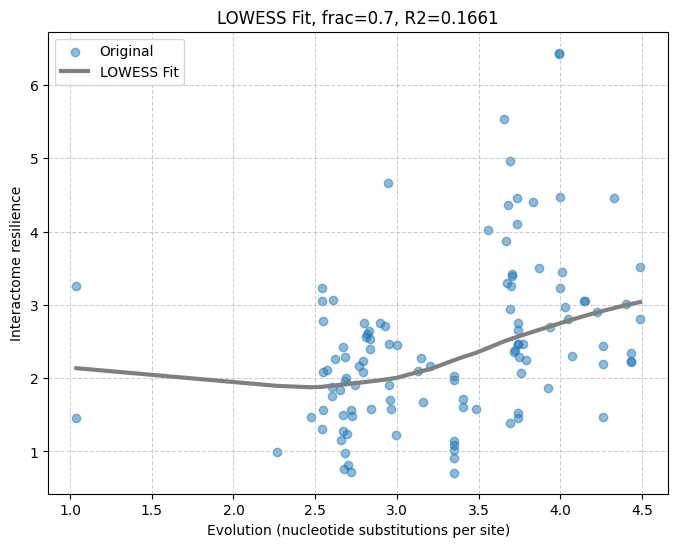

In [6]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# new_compressibilities = []
# new_evolutions = []
# print(f'Before filtering: {len(compressibilities)}')
# for i in range(len(compressibilities)):
#     if evolutions[i] >= 1.5:
#         new_compressibilities.append(compressibilities[i])
#         new_evolutions.append(evolutions[i])
# print(f'After filtering: {len(new_compressibilities)}')

# compressibilities = np.array(new_compressibilities)
# evolutions = np.array(new_evolutions)

# 2. 使用 statsmodels 进行 LOWESS 拟合
# lowess 函数返回一个数组，其中第一列是排序后的 x 值，第二列是对应的拟合 y 值
lowess_fit = sm.nonparametric.lowess(compressibilities, evolutions, frac=0.8)

# 提取排序后的 x 值和拟合的 y 值
x_fit = lowess_fit[:, 0]
y_fit = lowess_fit[:, 1]


# 3. 计算 R² (决定系数)
# R² = 1 - (残差平方和 / 总平方和)

# 首先，我们需要得到与原始数据点一一对应的拟合值
# 因为 lowess 的输出是根据 x 值排序的，我们需要使用插值来找到每个原始 evolution 点对应的 resilience 拟合值
y_hat = np.interp(evolutions, x_fit, y_fit)

# 计算总平方和 (SStot)
ss_tot = np.sum((compressibilities - np.mean(compressibilities))**2)

# 计算残差平方和 (SSres)
ss_res = np.sum((compressibilities - y_hat)**2)

# 计算 R²
r_squared = 1 - (ss_res / ss_tot)

print(f"R2: {r_squared:.4f}")


# 4. 可视化结果 (可选，但推荐)
plt.figure(figsize=(8, 6))
# 绘制原始数据散点图
plt.scatter(evolutions, compressibilities, label='Original', alpha=0.5)
# 绘制 LOWESS 拟合曲线
plt.plot(x_fit, y_fit, label='LOWESS Fit', color='gray', linewidth=3)
plt.xlabel('Evolution (nucleotide substitutions per site)')
plt.ylabel('Interactome resilience')
plt.title(f'LOWESS Fit, frac={0.7}, R2={r_squared:.4f}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [4]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm # 用于显示进度条，可选

# --- 函数：封装 LOWESS R² 计算过程 ---
def calculate_lowess_r2(x, y, frac=0.4):
    """
    对给定的 x, y 数据进行 LOWESS 拟合，并返回 R² 值。
    """
    # LOWESS 拟合
    lowess_fit = sm.nonparametric.lowess(y, x, frac=frac)
    x_fit = lowess_fit[:, 0]
    y_fit = lowess_fit[:, 1]
    
    # 通过插值找到每个原始 x 点对应的拟合 y 值
    y_hat = np.interp(x, x_fit, y_fit)
    
    # 计算 R²
    ss_tot = np.sum((y - np.mean(y))**2)
    ss_res = np.sum((y - y_hat)**2)
    
    # 防止 ss_tot 为 0 的情况
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
        
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# --- 1. 准备你的数据 ---
# 请将下面的示例数据替换为你自己的两个 list
np.random.seed(0)
evolution = evolutions
resilience = compressibilities

# --- 2. 计算观测到的真实 R² 值 ---
observed_r2 = calculate_lowess_r2(evolution, resilience)
print(f"观测到的真实 R² 值为: {observed_r2:.4f}")

# --- 3. 执行置换检验来计算 p 值 ---
n_permutations = 100000  # 置换次数，次数越多 p 值越精确
count_greater = 0      # 计数器：记录随机R²超过真实R²的次数

# 使用 tqdm 创建一个进度条，方便观察长时间运行的进度
for i in tqdm(range(n_permutations), desc="正在进行置换检验..."):
    # 随机打乱 evolution 数据的顺序
    shuffled_evolution = np.random.permutation(evolution)
    
    # 对打乱后的数据计算 R²
    permuted_r2 = calculate_lowess_r2(shuffled_evolution, resilience)
    
    # 如果随机 R² 大于或等于观测 R²，则计数器加一
    if permuted_r2 >= observed_r2:
        count_greater += 1

# --- 4. 计算并输出最终的 p 值 ---
if count_greater == 0:
    p_value_string = f"< {1/n_permutations}"
else:
    p_value = count_greater / n_permutations
    p_value_string = f"= {p_value}"

print(f"经过 {n_permutations} 次置换检验后, p 值为: {p_value_string}")


观测到的真实 R² 值为: 0.2732


正在进行置换检验...: 100%|██████████| 100000/100000 [05:06<00:00, 326.41it/s]

经过 100000 次置换检验后, p 值为: = 2e-05
